In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_text = pd.read_csv('../Data/ProcessedTweets.csv')
df = pd.DataFrame(data_text)
#df.columns = ['id','content']
#data_text = df.drop('id',axis=1)
data_text = data_text.dropna()
#df.to_csv('ProcessedTweets.csv',index=True)


# Clustering text documents using k-means


This is an example showing how the scikit-learn can be used to cluster
documents by topics using a bag-of-words approach. This example uses
a scipy.sparse matrix to store the features instead of standard numpy arrays.

Two feature extraction methods can be used in this example:

  - TfidfVectorizer uses a in-memory vocabulary (a python dict) to map the most
    frequent words to features indices and hence compute a word occurrence
    frequency (sparse) matrix. The word frequencies are then reweighted using
    the Inverse Document Frequency (IDF) vector collected feature-wise over
    the corpus.

  - HashingVectorizer hashes word occurrences to a fixed dimensional space,
    possibly with collisions. The word count vectors are then normalized to
    each have l2-norm equal to one (projected to the euclidean unit-ball) which
    seems to be important for k-means to work in high dimensional space.

    HashingVectorizer does not provide IDF weighting as this is a stateless
    model (the fit method does nothing). When IDF weighting is needed it can
    be added by pipelining its output to a TfidfTransformer instance.

Two algorithms are demoed: ordinary k-means and its more scalable cousin
minibatch k-means.

Additionally, latent semantic analysis can also be used to reduce
dimensionality and discover latent patterns in the data.

It can be noted that k-means (and minibatch k-means) are very sensitive to
feature scaling and that in this case the IDF weighting helps improve the
quality of the clustering by quite a lot as measured against the "ground truth"
provided by the class label assignments of the 20 newsgroups dataset.

This improvement is not visible in the Silhouette Coefficient which is small
for both as this measure seem to suffer from the phenomenon called
"Concentration of Measure" or "Curse of Dimensionality" for high dimensional
datasets such as text data. Other measures such as V-measure and Adjusted Rand
Index are information theoretic based evaluation scores: as they are only based
on cluster assignments rather than distances, hence not affected by the curse
of dimensionality.

Note: as k-means is optimizing a non-convex objective function, it will likely
end up in a local optimum. Several runs with independent random init might be
necessary to get a good convergence.




In [3]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

#dataset = fetch_20newsgroups(subset='all', categories=categories,
#                             shuffle=True, random_state=42)

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Loading 20 newsgroups dataset for categories:
None


In [4]:

#print("%d documents" % len(dataset.data))
#print("%d categories" % len(dataset.target_names))
print()

#labels = dataset.target
true_k = 10

print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
#if opts.use_hashing:
#    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
#        hasher = HashingVectorizer(n_features=opts.n_features,
#                                   stop_words='english', alternate_sign=False,
#                                   norm=None, binary=False)
#        vectorizer = make_pipeline(hasher, TfidfTransformer())
#    else:
#        vectorizer = HashingVectorizer(n_features=opts.n_features,
#                                       stop_words='english',
#                                       alternate_sign=False, norm='l2',
#                                       binary=False)
#else:
vectorizer = TfidfVectorizer(stop_words='english',
                             use_idf=True,analyzer='word',token_pattern='[a-zA-Z0-9]{2,}',
                             lowercase=True)
X = vectorizer.fit_transform(data_text['content'])
dfx = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
print(dfx)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()



Extracting features from the training dataset using a sparse vectorizer
        00  000  0000  000hermansjr000  000th  007  007cigarjoe  007llisav  \
0      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
1      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
2      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
3      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
4      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
5      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
6      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
7      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
8      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
9      0.0  0.0   0.0              0.0    0.0  0.0          0.0        0.0   
10     0.0  0.0   0.0              0.0    0.0  0.0          0.0      

In [5]:

print("Performing dimensionality reduction using LSA")
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = svd.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

Performing dimensionality reduction using LSA
done in 0.452807s
Explained variance of the SVD step: 1%




  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:07<00:22,  7.50s/it]

 50%|█████     | 2/4 [00:16<00:15,  7.98s/it]

 75%|███████▌  | 3/4 [00:40<00:12, 12.80s/it]

 25%|██▌       | 1/4 [01:51<05:34, 111.39s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:17<02:05, 17.98s/it]

 25%|██▌       | 2/8 [00:23<01:25, 14.28s/it]

 38%|███▊      | 3/8 [00:29<00:58, 11.77s/it]

 50%|█████     | 4/8 [00:35<00:39,  9.91s/it]

 62%|██████▎   | 5/8 [00:39<00:24,  8.19s/it]

 75%|███████▌  | 6/8 [00:47<00:16,  8.12s/it]

 88%|████████▊ | 7/8 [01:04<00:10, 10.80s/it]

 50%|█████     | 2/4 [04:14<04:01, 120.99s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:04,  2.24it/s]

 20%|██        | 2/10 [00:06<00:16,  2.09s/it]

 30%|███       | 3/10 [00:07<00:13,  1.94s/it]

 40%|████      | 4/10 [00:09<00:11,  1.95s/it]

 50%|█████     | 5/10 [00:10<00:07,  1.50s/it]

 60%|██████    | 6/10 [00:32<00:30, 

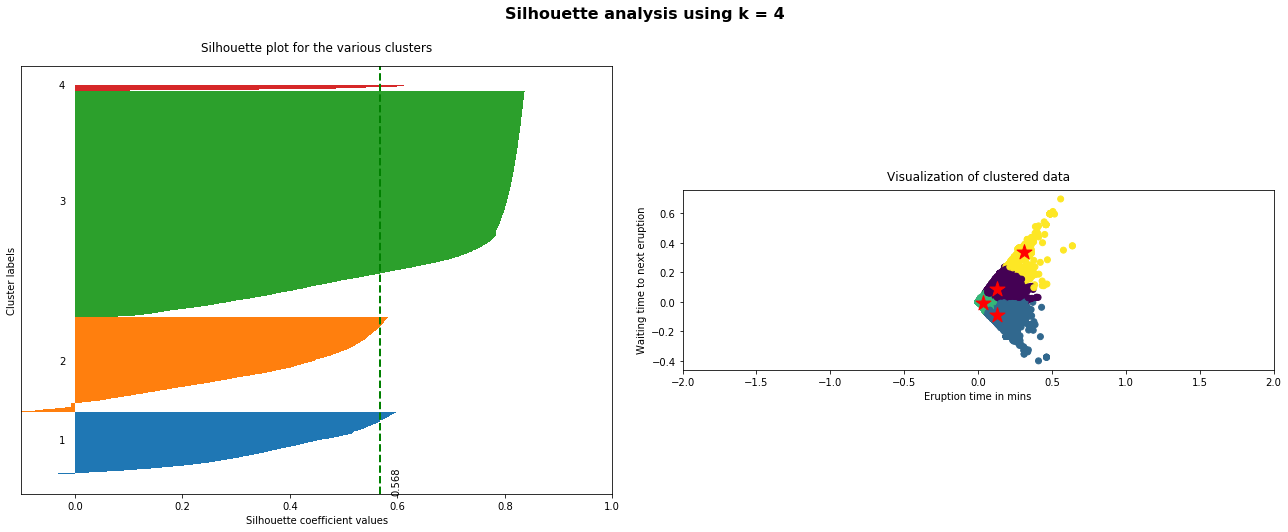

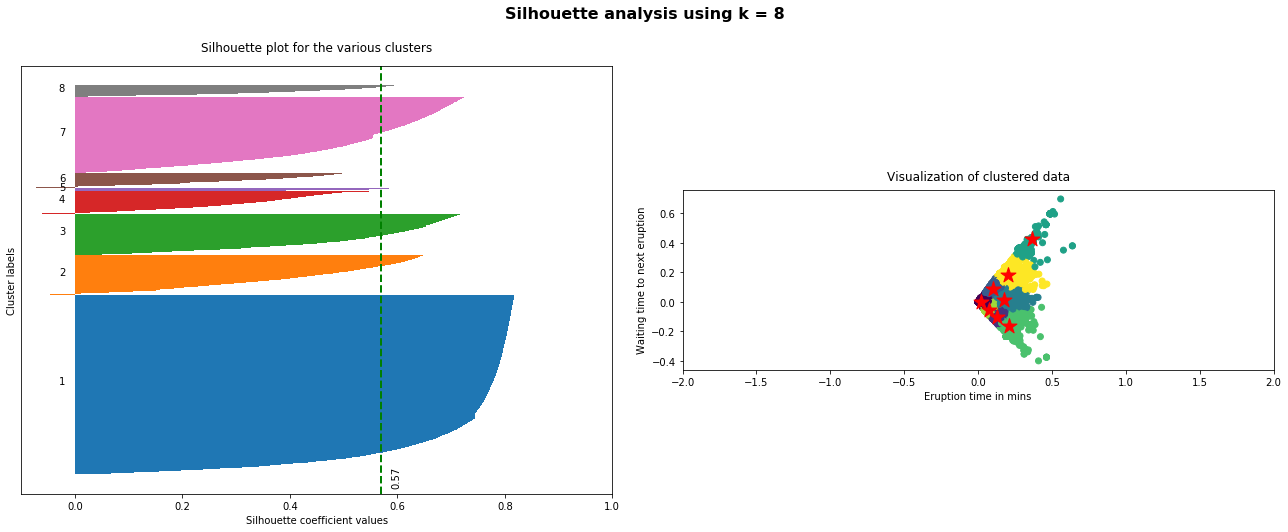

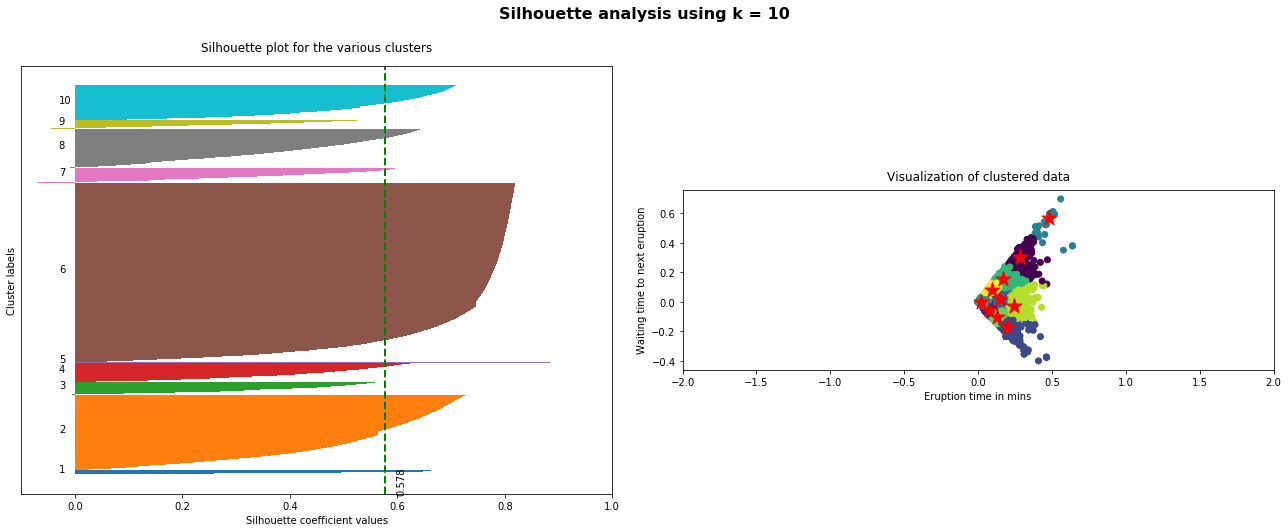

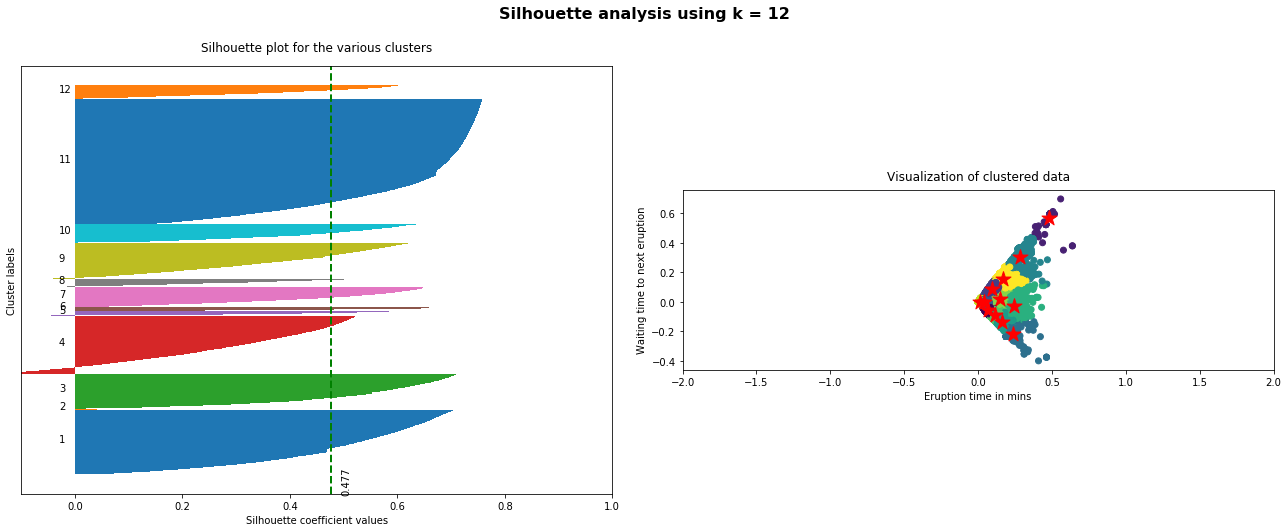

In [22]:
## Silhouette Evaluation for k = 4,8,10,12
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
for i, k in enumerate(tqdm([4,8,10,12])):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(tqdm(np.unique(labels))):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.text(avg_score + 0.02,0,str(round(avg_score, 3)),rotation=90)
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

    # Scatter plot of data colored with labels
    ax2.scatter(X[:, 0], X[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
    fig.savefig('resultsSilhouette'+str(k)+'.png',format='png')

1
2
3
4
5
6
7
8
9
10
11
12
13
14


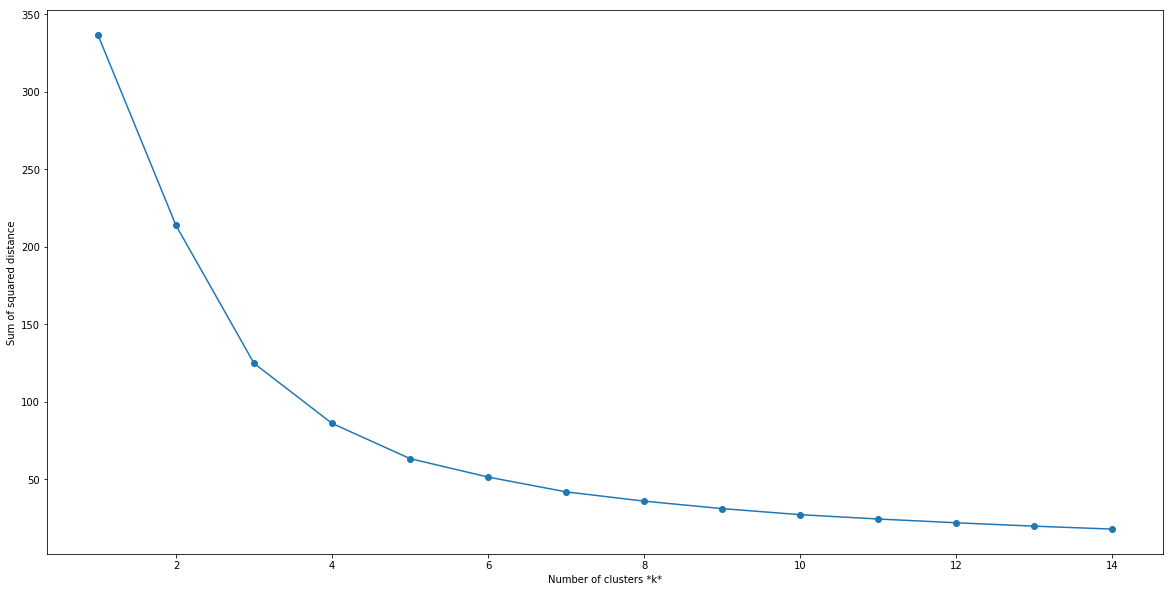

In [6]:
# #############################################################################
# Do the actual clustering and Elbow Method Evaluation

sse = []
list_k = list(range(1, 15))

for k in list_k:
    #km = KMeans(n_clusters=k)
    print(k)
    km = KMeans(n_clusters=k, init='k-means++', n_init=50,
                verbose=False,max_iter=100)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(20, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.savefig('elbow.png',format='png')


        

2019-04-01 15:13:14,997 WARNING No handles with labels found to put in legend.


Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=50, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.036s

Top terms per cluster:


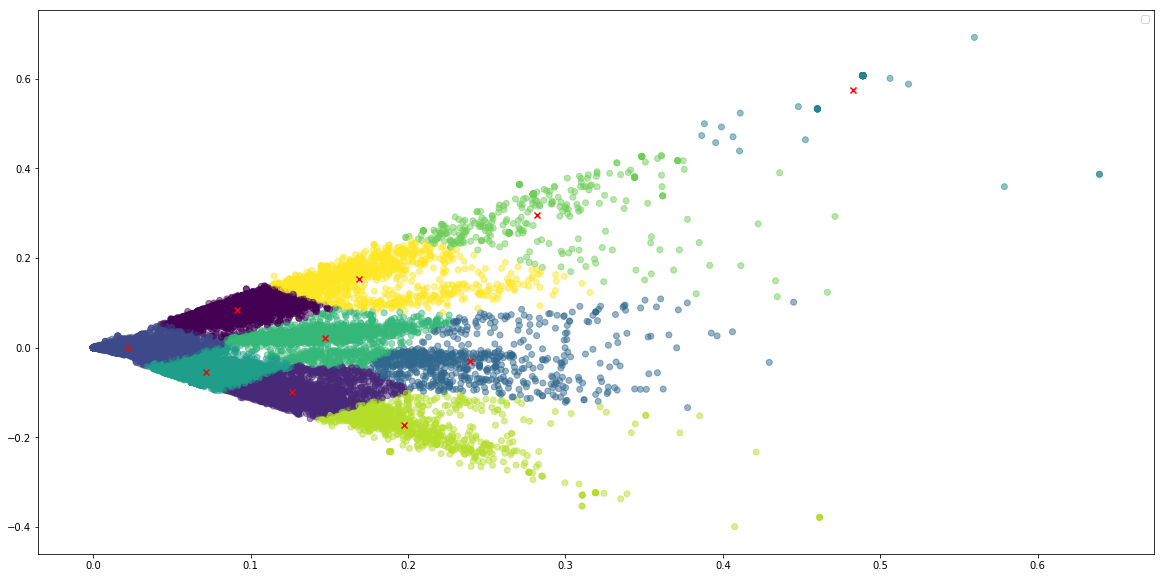

Cluster 0: great america thank trump2016 makeamericagreatagain people realdonaldtrump country today honor
Cluster 1: realdonaldtrump trump president thanks donald twitter false android country obama
Cluster 2: realdonaldtrump great trump thank president america thanks donald country trump2016
Cluster 3: realdonaldtrump great trump president thank america thanks donald country twitter
Cluster 4: great america thank trump2016 makeamericagreatagain people country honor today going
Cluster 5: realdonaldtrump trump president thanks donald twitter false android country obama
Cluster 6: great realdonaldtrump thank america trump president thanks donald trump2016 country
Cluster 7: great america thank trump2016 makeamericagreatagain people country today honor going
Cluster 8: realdonaldtrump trump president thanks donald twitter false android country obama
Cluster 9: great america thank trump2016 makeamericagreatagain people realdonaldtrump country today honor


In [7]:
print("Clustering sparse data with %s" % km)
t0 = time()

dfx['cluster'] = km.labels_
print("done in %0.3fs" % (time() - t0))
print()

plt.figure(figsize=(20,10))
#plt.scatter(Xpca[km.labels_==0,0], Xpca[km.labels_==0,1], c = 'green',alpha=0.5)
#plt.scatter(Xpca[km.labels_==1,0], Xpca[km.labels_==1,1], c = 'blue',alpha=0.5)
plt.scatter(X[:,0],X[:,1],c=km.labels_.astype(float), alpha = 0.5)
#plt.scatter(Xpca[:,0], Xpca[:,1], c = km.labels_.astype(float),alpha=0.5, label = km.labels_)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color = 'red',marker='x')
plt.legend()
plt.show()
km.cluster_centers_
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
   
terms = vectorizer.get_feature_names()
for i in range(true_k):
    #print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        #print(' %s' % terms[ind], end='')
    print()

In [7]:
print(len(km.labels_))
print(km.labels_)
data_text['labels']=km.labels_
data_text.reset_index(inplace=True)
print(data_text)
count = dict()
unique, counts = np.unique(data_text['labels'], return_counts=True)
dict(zip(unique, counts))

31412
[6 4 4 ... 9 9 9]
       index                                            content  labels
0          0  great republican senator ineffective border se...       6
1          1  former senator harry throw working fail career...       4
2          2  meeting breakfast nation governor vietnam impo...       4
3          3  realdonaldtrump funny watch people fail years ...       0
4          4  ivankatrump admin commit ensure american skill...       4
5          5    price getting please relax world price fragile        4
6          6  spike could note better note racist president ...       0
7          7  realdonaldtrump highly respect senator richard...       0
8          8  state emergency southern border border patrol ...       6
9          9  please report substantial progress trade talks...       4
10        10  funny watch people fail years nothing telling ...       0
11        11  collusion russian crook hillary clinton democr...       4
12        12  approval rating republican

{0: 6080,
 1: 1526,
 2: 342,
 3: 1054,
 4: 14499,
 5: 1157,
 6: 2793,
 7: 707,
 8: 75,
 9: 3179}

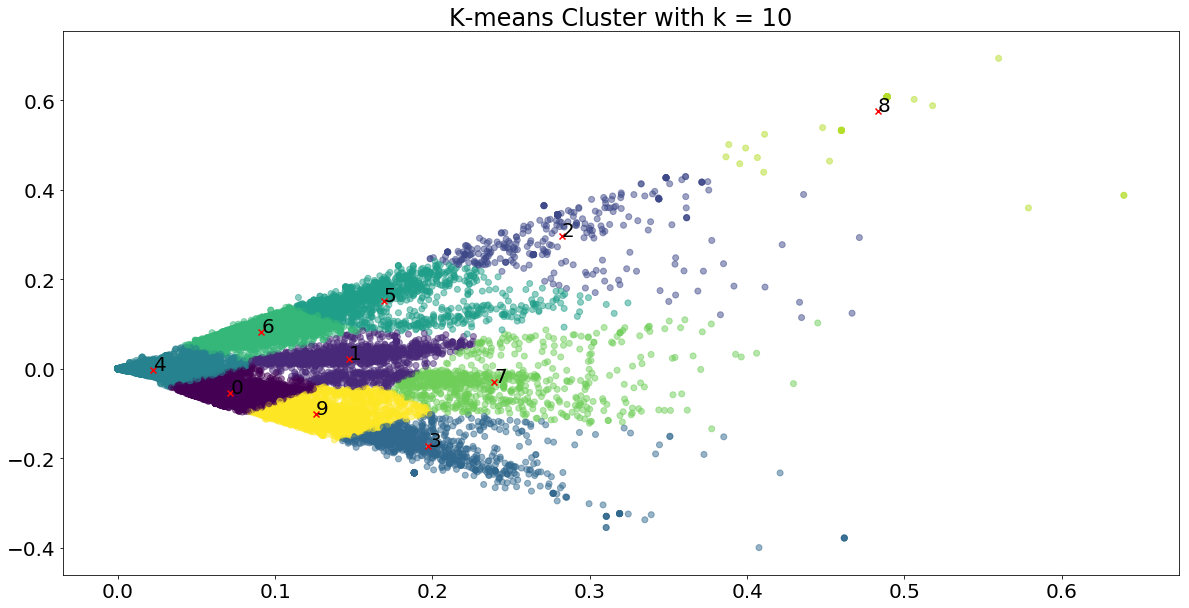

In [9]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 20})
plt.scatter(X[:,0],X[:,1],c=km.labels_.astype(float), alpha = 0.5)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], color = 'red',marker='x')
for i in range(0,true_k):
    plt.annotate(i,((km.cluster_centers_[i,0], km.cluster_centers_[i,1])))
plt.title('K-means Cluster with k = 10')
plt.savefig('kmeansFinal.png')
plt.show()